<a href="https://colab.research.google.com/github/CalebAnderson22/PHY122/blob/main/Lab6_Anderson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lab 6

Caleb Anderson

30 November 2024

#   <font color='Green'> **Setup** </font>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, linewidth=200, threshold=2000, suppress=True)

π = np.pi

In [ ]:
import scipy
from scipy.special import ellipj, ellipk

def get_radian(deg):
    return π * deg / 180

def get_degree(rad):
    return 180 * rad / π

def get_ω(time):
    dtt = time[1] - time[0]
    return 2*π * np.linspace(0.0, 1.0/(2.0*dtt), int(len(time)/2))

def get_Qdot(Q, L, IIi):

    ω = np.append([0.],  IIi @ L)

    B = 0.5*np.asarray([[ Q[0], -Q[1], -Q[2], -Q[3] ],
                        [ Q[1],  Q[0], -Q[3],  Q[2] ],
                        [ Q[2],  Q[3],  Q[0], -Q[1] ],
                        [ Q[3], -Q[2],  Q[1],  Q[0] ]])

    return B @ ω

def get_EulerAngles(Q):

    φ = np.arctan2( 2*(Q[0]*Q[1] + Q[2]*Q[3]) , 1 - 2*(Q[1]**2 + Q[2]**2) )
    θ = np.arcsin(  2*(Q[0]*Q[2] + Q[3]*Q[1] ) ) ## np.tan() ?? np.arcsin
    ψ = np.arctan2( 2*(Q[0]*Q[3] + Q[1]*Q[2]) , 1 - 2*(Q[2]**2 + Q[3]**2) )

    return np.asarray([φ, θ, ψ])

def get_Qauternions(Θ):

    φ = Θ[0]
    θ = Θ[1]
    ψ = Θ[2]

    ## Q[0] has all cosines, then for each component replace one sine, then add/subtract the flip of this
    Q = np.asarray([ np.cos(φ/2)*np.cos(θ/2)*np.cos(ψ/2) + np.sin(φ/2)*np.sin(θ/2)*np.sin(ψ/2),
                     np.sin(φ/2)*np.cos(θ/2)*np.cos(ψ/2) - np.cos(φ/2)*np.sin(θ/2)*np.sin(ψ/2),
                     np.cos(φ/2)*np.sin(θ/2)*np.cos(ψ/2) + np.sin(φ/2)*np.cos(θ/2)*np.sin(ψ/2),
                     np.cos(φ/2)*np.cos(θ/2)*np.sin(ψ/2) - np.sin(φ/2)*np.sin(θ/2)*np.cos(ψ/2)])

    return Q

def sn(arg, k):
    sn = scipy.special.ellipj( arg , k)[0]
    return np.nan_to_num(sn, nan=1.)


def EllipticK(k):
    return scipy.special.ellipk(k)


class PhysicalPendulum(object):
    # 6/30/21
    ''' Pendulum Initialization '''
    def __init__(self):

        ### Constants
        self.g    = 9.81 # meters/second-squared : gravitational acceleration
        self.L    = 1.00 # meters : moment-of-inertia length
        #self.R    = 1.00 # meters : rotation-arm length
        self.drag = 0.00 # kg/seconds : Stokes drag / viscous damping coefficient
        self.mass = 1.00 # kg

        ### calculated constants
        self.I    = self.mass * (self.L)**2 # moment-of-inerta for point-mass around L
        self.II   = self.I * np.eye(3)
        self.IIi  = np.linalg.inv(self.II)
        self.C1   = self.IIi * self.drag
        self.C2   = self.IIi * self.L * self.mass * self.g
        self.ω0   = np.sqrt( self.C2[0][0] )

        ### calculations
        self.angle0      = None
        self.dynamicsrun = None
        self.dynamicst   = None
        self.freqprofile = None
        self.freq        = None

    def dynamics(self, Θ_0, dt=0.01, T=100, ω_0=[0.,0.,0.], error=0.25, dimension=1):

        ### calculated constants
        self.Θ    = Θ_0
        self.I    = self.mass * (self.L)**2 # moment-of-inerta for point-mass around L
        self.II   = self.I * np.eye(3)
        self.IIi  = np.linalg.inv(self.II)
        self.C1   = self.IIi * self.drag
        self.C2   = self.IIi * self.L * self.mass * self.g
        self.ω0   = np.sqrt( self.C2[0][0] )

        self.angle0 = Θ_0
        Θ_0    = np.asarray([Θ_0, 0.0, 0.0])
        Θ_0    = get_radian(Θ_0)
        L      = self.II @ ω_0
        time   = np.arange(0, T, dt)
        Q      = get_Qauternions(Θ_0)
        θ_data = np.zeros( (time.shape[0], 3) )

        for i in range(len(time)):

            θ_data[i] = get_degree( get_EulerAngles(Q) + (Θ_0[0]/180) * error*(np.random.rand(3) - 0.5) )

            τ = self.II @ ( - self.C2 @ np.sin(get_EulerAngles(Q)) - self.C1 @ ( self.IIi @ L ) ) ## leave τ & L in Euler angles!

            L_t = L + dt * τ / 2
            L   = L + dt * τ

            Qdot_t = get_Qdot(Q, L_t, self.IIi)
            Qdt = Q + dt/2 * Qdot_t

            Qdot_tdt = get_Qdot(Qdt, L, self.IIi)
            Q = Q + dt * Qdot_tdt

        self.dynamicst   = time
        self.dynamicsrun = (θ_data[:,:dimension].T)[0]

        return self.dynamicst , self.dynamicsrun

    def frequency(self):
        self.freq   = get_ω(self.dynamicst)
        self.freqprofile = np.abs(2.0/len(self.dynamicst) * (np.fft.fft( self.dynamicsrun, axis=0 ))[:len(self.dynamicst)//2])
        self.getmax = self.freq[np.argmax(self.freqprofile)]
        return self.freq / (2 * np.pi), self.freqprofile

    def exactdynamics(self):
        t = self.dynamicst

        k  = np.sin( get_radian(self.angle0)/2 )**2
        K  = scipy.special.ellipk(k)
        Θt  = self.angle0 * sn(self.ω0 * t + K , k)

        return Θt

#   <font color='Red'> **Getting Started** </font>

####   <font color='Red'> To get started, let's define a pendulum object </font>

In [ ]:
Experiment = PhysicalPendulum()

####   <font color='Red'> Next, let's change the objects: mass, L (length), gravity. </font>

In [ ]:
Experiment.L = 1
Experiment.mass = 10
Experiment.g = 9.81

####   <font color='Red'> Next, let's run the dynamics with an ideal release angle of your choice (in degrees). </font>

In [ ]:
t, Θ_t = Experiment.dynamics(5, error=0.0, dt=0.1, T = 100)

####   <font color='Red'> Next, let's plot our dynamics results. </font>

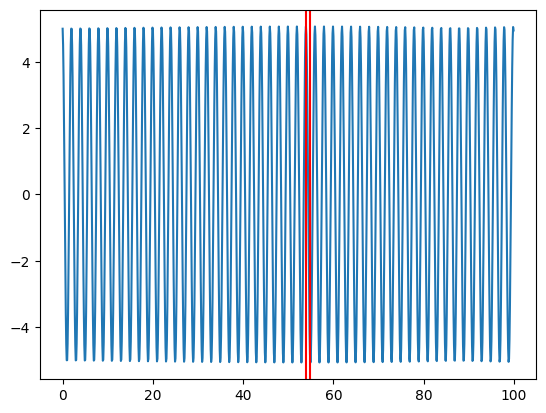

In [ ]:
plt.plot(t, Θ_t)
plt.axvline(x=53.9, color='red')
plt.axvline(x=54.9, color='red')
plt.show()

###   <font color='Red'> Determine-and-Print the Period & the frequency of the plot above, using only the graph (and data above): </font>

In [ ]:
print(np.max(Θ_t))
print(np.min(Θ_t))
print(np.where(Θ_t == np.max(Θ_t)))
print(np.where(Θ_t == np.min(Θ_t)))

5.067993136673078
-5.068014157612662
(array([539]),)
(array([549]),)


Half-period between t=53.9 s and t=54.9 s. Therefore, full period is 2 s. Frequency and period are inversely related, so f = 0.5 Hz.

###   <font color='Red'> Next lets determine the frequency-profile of this simulation: </font>

In [ ]:
f, S = Experiment.frequency()
S_peak = np.max(S)
S_peak_index= np.argmax(S)
freq_peak = f[S_peak_index]
print(S_peak)
print(S_peak_index)
print(freq_peak)

5.039775565867981
50
0.501002004008016


#   <font color='Red'> **Mass Experiment** </font>

### <font color='Green'> Implement the *for-loop-over-object* stragey to scan over object parameters.</font>

In [ ]:
Masses = np.arange(0.1, 10, 0.1)
freqs  = np.empty(len(Masses))

for i in range(len(Masses)):

    MassExperiment = PhysicalPendulum()
    MassExperiment.L    = 1 ## m
    MassExperiment.mass = Masses[i] ## kg
    MassExperiment.g    = 9.81 ## m/s/s

    t, Θ_t = MassExperiment.dynamics(5, error=0.0, dt=0.1, T = 100)
    f, S   = MassExperiment.frequency()

freqs[i] = f[np.argmax(S)]

###   <font color='Red'> Next let's plot our results: </font>

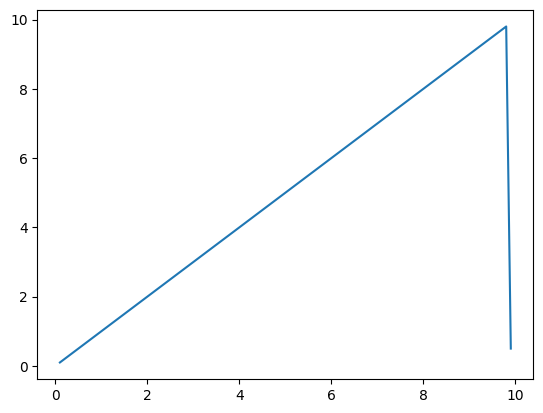

In [ ]:
plt.plot(Masses, freqs)
plt.show()

#   <font color='Red'> **Length Experiment** </font>

### <font color='Red'> Implement the *for-loop-over-object* stragey to scan over object parameters.</font>

In [ ]:
Lengths = np.arange(0.1, 10, 0.1)
freqs  = np.empty(len(Lengths))

for i in range(len(Lengths)):

    LengthExperiment = PhysicalPendulum()
    LengthExperiment.L    = Lengths[i] ## m
    LengthExperiment.mass = 1 ## kg
    LengthExperiment.g    = 9.81 ## m/s/s

    t, Θ_t = LengthExperiment.dynamics(5, error=0.0, dt=0.1, T = 100)
    f, S   = LengthExperiment.frequency()

freqs[i] = f[np.argmax(S)]

###   <font color='Red'> Let's plot our results as-is: </font>

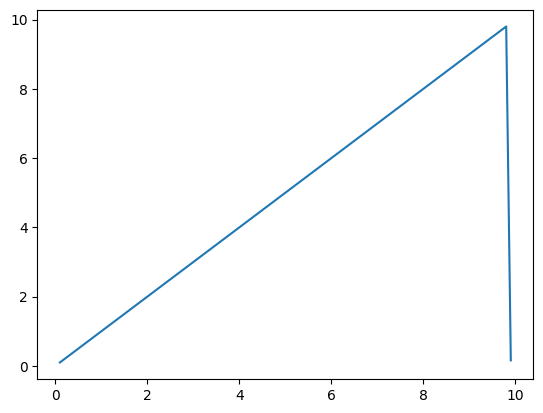

In [ ]:
plt.plot(Lengths, freqs)
plt.show()

###   <font color='Red'> Let's plot our results in a linearized form: </font>

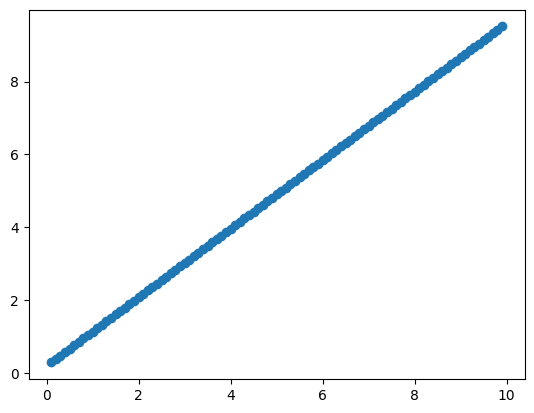

In [ ]:
def linearfit(x,y):
  A = np.vstack([x, np.ones(len(x))]).T
  return np.linalg.lstsq(A, y, rcond=None)[0]

linearlength = linearfit(Lengths, freqs)
x=np.arange(0.1,10,0.1)
plt.scatter(x, linearlength[0]*x + linearlength[1], label = "Data linear fit")

#   <font color='Red'> **Gravitational Acceleration** </font>

### <font color='Red'> Implement the *for-loop-over-object* stragey to scan over object parameters.</font>

In [ ]:
Gs = np.arange(0.1, 10, 0.1)
freqs  = np.empty(len(Gs))

for i in range(len(Gs)):

    GExperiment = PhysicalPendulum()
    GExperiment.L    = 10 ## m
    GExperiment.mass = 1 ## kg
    GExperiment.g    = Gs[i] ## m/s/s

    t, Θ_t = GExperiment.dynamics(5, error=0.0, dt=0.1, T = 100)
    f, S   = GExperiment.frequency()

freqs[i] = f[np.argmax(S)]

###   <font color='Red'> Let's plot our results as-is: </font>

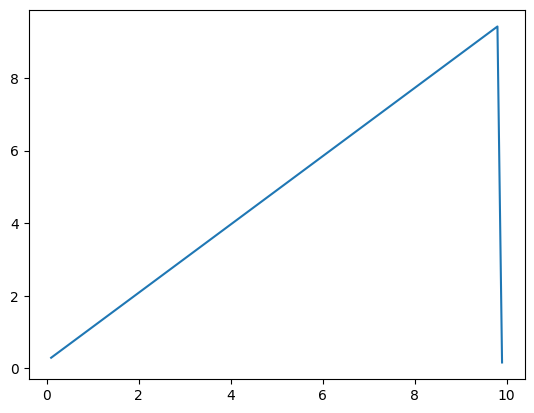

In [ ]:
plt.plot(Gs, freqs)
plt.show()

###   <font color='Red'> Let's plot our results in linearized form: </font>

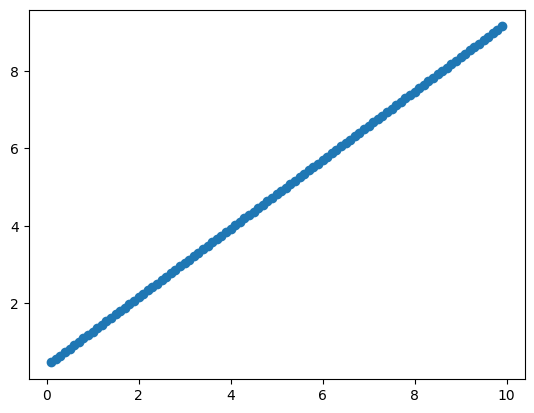

In [ ]:
linearg=linearfit(Gs, freqs)
x=np.arange(0.1,10,0.1)
plt.scatter(x, linearg[0]*x + linearg[1], label = "Data linear fit")

#   <font color='Red'> **Release Angle (small)** </font>

### <font color='Red'> Implement the *for-loop-over-object* stragey to scan over object parameters.</font>

In [40]:
Thetas = np.arange(0.1, 5, 0.1)
freqs  = np.empty(len(Thetas))

for i in range(len(Thetas)):

    TExperiment = PhysicalPendulum()
    TExperiment.L    = 10 ## m
    TExperiment.mass = 5 ## kg
    TExperiment.g    = 9.81 ## m/s/s

    t, Θ_t = TExperiment.dynamics(Thetas[i], error=0.0, dt=0.1, T = 100)
    f, S   = TExperiment.frequency()

freqs[i] = f[np.argmax(S)]

###   <font color='Red'> Let's plot our results as-is: </font>

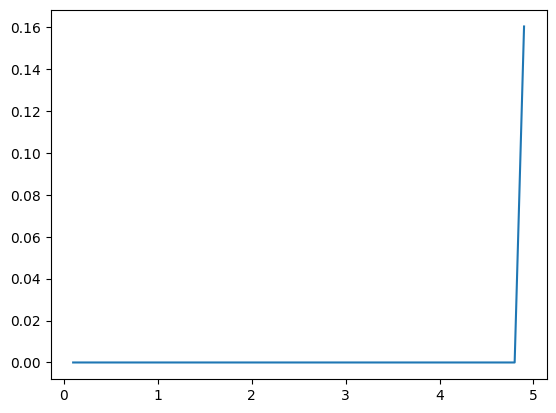

In [41]:
plt.plot(Thetas, freqs)
plt.show()

#   <font color='Red'> **Conclusion** </font>

I have to admit, I was a little surprised by the way these experiments turned out.

#   <font color='Red'> **Describe the Small Angle Approximation** </font>

The small angle approximation enables easier calculation of nonliner (i.e., sinusoidal) relationships given that for very small values of θ, the Taylor-Maclaurin series for sinθ has trivially small contributions from every term after the first term, which is simply θ. Thus, though it is always valid to express sinθ by its series approximation, for very small θ it is further appropriate to reduce the approximation itself down to a single, linear term. Given that the physical circumstances are appropriate, this can save a lot of unneccessary headache and computational expenditure for the physical scientist.

#   <font color='Red'> **What happens at θ_0 = 0° and θ_0 = 180°? What is the period/frequency?** </font>

At these unique initial conditions, the centripetal and gravitational acceleration are parallel and anti-parallel, and the pendulum thus remains still for all time (given an ideal set of circumstances, of course). Since the pendulum stays still for all time, it never completes an oscillation, meaning its period is effectively infinity seconds . Given a period of infinity seconds, the frequency is 0 Hz.